In [1]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 
NPY_INPUT_DIR = '../data/extracted_features/combined_ML/irma/'
NPY_OUTPUT_DIR = '../data/resultsML/irma/'

NUM_TESTS = 25

HIDDEN_DIM0 = 271
NUM_LAYERS0 = 2
BIDIRECTIONAL = True
LEARNING_RATE0 =  0.011715295017547324
IMAGE_HIDDEN= 137
DECAY_FACTOR0 = 0.11585060673156092
EPOCH0 = 4

HIDDEN_DIM1 = 69
NUM_LAYERS1 = 2
ACTIVATION1 = torch.relu
LEARNING_RATE1 =  0.018543336315269637
MOMENTUM1= 0.9
DECAY_FACTOR1 =  0.1086151066422733
EPOCH1 = 4

HIDDEN_DIM2 = 273
NUM_LAYERS2 = 2
ACTIVATION2 = torch.relu
LEARNING_RATE2 =   0.02095663890266602
MOMENTUM2= 0.9
DECAY_FACTOR2 =  0.9076410256673466
EPOCH2 = 1



# LSTM -------------------------------------------------------------------*

In [3]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test, X_img_train, X_img_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, img_hidden_dim = IMAGE_HIDDEN,
                          num_layers = NUM_LAYERS0, bidirectional = BIDIRECTIONAL,
                          learning_rate = LEARNING_RATE0,decay_factor = DECAY_FACTOR0)
        model.learn(X_train, X_img_train, y_train, epochs=EPOCH0)
        
        # evaluate
        acc, auc, precision, recall, f1 = model.get_acc_auc_pre_re_f1(X_test, X_img_test, y_test)
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = model.get_accuracy_graph(X_test, X_img_test, y_test, y_train.numpy())
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'lstm_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [4]:
# load data from files
X_seq_img_train = np.load(NPY_INPUT_DIR + 'images_lstm_train.npz', allow_pickle=True)
X_seq_img_test = np.load(NPY_INPUT_DIR + 'images_lstm_test.npz', allow_pickle=True)

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))


# build lists with features concatenated
# img feat
X_raw_img_train = []
for i in range(len(y_train)):
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_raw_img_train.append(hist[j])

img_scaler = StandardScaler()
X_img_fit_train = np.concatenate(X_raw_img_train) # a stack of all image feat
img_scaler.fit(X_img_fit_train)

# now build list of list of normalized 2d matricies representing all img in a tweet
X_img_train = []
for i in range(len(y_train)):
    X_i_img = []
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_train.append(X_i_img)
    
X_img_test = []
for i in range(len(y_test)):
    X_i_img = []
    file = X_seq_img_test.files[i]
    hist = X_seq_img_test[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_test.append(X_i_img)

# lang feat
X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


Strating ************************************************* 0
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.488
[1,   400] loss: 0.374
[1,   600] loss: 0.316
[1,   800] loss: 0.403
[1,  1000] loss: 0.353
[1,  1200] loss: 0.361
[1,  1400] loss: 0.350
[1,  1600] loss: 0.330
[1,  1800] loss: 0.337
[1,  2000] loss: 0.408
[1,  2200] loss: 0.302
[1,  2400] loss: 0.359
[1,  2600] loss: 0.374
[1,  2800] loss: 0.388
[1,  3000] loss: 0.368
[1,  3200] loss: 0.374
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.272
[2,   400] loss: 0.331
[2,   600] loss: 0.255
[2,   800] loss: 0.260
[2,  1000] loss: 0.360
[2,  1200] loss: 0.251
[2,  1400] loss: 0.295
[2,  1600] loss: 0.234
[2,  1800] loss: 0.202
[2,  2000] loss: 0.315
[2,  2200] loss: 0.204
[2,  2400] loss: 0.259
[2,  2600] loss: 0.248
[2,  2800] loss: 0.214
[2,  3000] loss: 0.290
[2,  3200] loss: 0.296
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.268
[3,   400] loss: 0.216
[3,   600] loss:

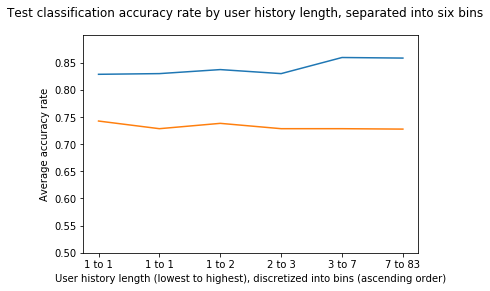

Strating ************************************************* 1
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.487
[1,   400] loss: 0.371
[1,   600] loss: 0.313
[1,   800] loss: 0.404
[1,  1000] loss: 0.353
[1,  1200] loss: 0.360
[1,  1400] loss: 0.349
[1,  1600] loss: 0.328
[1,  1800] loss: 0.339
[1,  2000] loss: 0.406
[1,  2200] loss: 0.304
[1,  2400] loss: 0.355
[1,  2600] loss: 0.377
[1,  2800] loss: 0.387
[1,  3000] loss: 0.372
[1,  3200] loss: 0.375
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.271
[2,   400] loss: 0.332
[2,   600] loss: 0.256
[2,   800] loss: 0.260
[2,  1000] loss: 0.359
[2,  1200] loss: 0.252
[2,  1400] loss: 0.293
[2,  1600] loss: 0.234
[2,  1800] loss: 0.205
[2,  2000] loss: 0.312
[2,  2200] loss: 0.202
[2,  2400] loss: 0.258
[2,  2600] loss: 0.247
[2,  2800] loss: 0.213
[2,  3000] loss: 0.290
[2,  3200] loss: 0.300
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.269
[3,   400] loss: 0.211
[3,   600] loss:

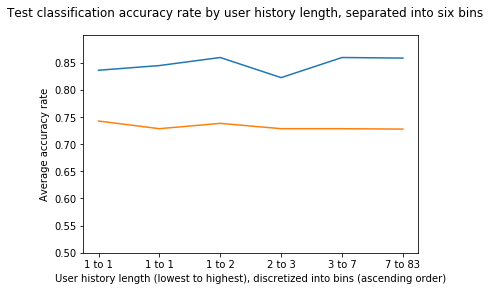

Strating ************************************************* 2
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.486
[1,   400] loss: 0.372
[1,   600] loss: 0.313
[1,   800] loss: 0.406
[1,  1000] loss: 0.352
[1,  1200] loss: 0.356
[1,  1400] loss: 0.350
[1,  1600] loss: 0.329
[1,  1800] loss: 0.340
[1,  2000] loss: 0.407
[1,  2200] loss: 0.302
[1,  2400] loss: 0.357
[1,  2600] loss: 0.379
[1,  2800] loss: 0.386
[1,  3000] loss: 0.372
[1,  3200] loss: 0.374
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.269
[2,   400] loss: 0.334
[2,   600] loss: 0.254
[2,   800] loss: 0.260
[2,  1000] loss: 0.359
[2,  1200] loss: 0.255
[2,  1400] loss: 0.291
[2,  1600] loss: 0.234
[2,  1800] loss: 0.204
[2,  2000] loss: 0.315
[2,  2200] loss: 0.201
[2,  2400] loss: 0.260
[2,  2600] loss: 0.247
[2,  2800] loss: 0.208
[2,  3000] loss: 0.291
[2,  3200] loss: 0.296
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.268
[3,   400] loss: 0.213
[3,   600] loss:

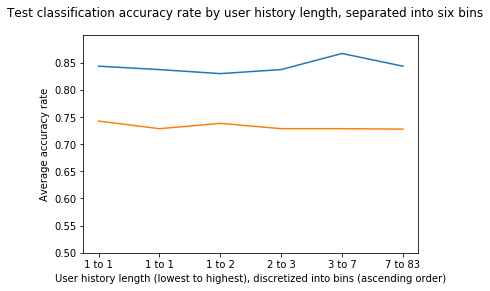

Strating ************************************************* 3
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.490
[1,   400] loss: 0.373
[1,   600] loss: 0.315
[1,   800] loss: 0.403
[1,  1000] loss: 0.351
[1,  1200] loss: 0.354
[1,  1400] loss: 0.351
[1,  1600] loss: 0.333
[1,  1800] loss: 0.334
[1,  2000] loss: 0.407
[1,  2200] loss: 0.306
[1,  2400] loss: 0.355
[1,  2600] loss: 0.375
[1,  2800] loss: 0.387
[1,  3000] loss: 0.368
[1,  3200] loss: 0.374
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.270
[2,   400] loss: 0.332
[2,   600] loss: 0.256
[2,   800] loss: 0.259
[2,  1000] loss: 0.363
[2,  1200] loss: 0.251
[2,  1400] loss: 0.292
[2,  1600] loss: 0.239
[2,  1800] loss: 0.201
[2,  2000] loss: 0.312
[2,  2200] loss: 0.200
[2,  2400] loss: 0.257
[2,  2600] loss: 0.245
[2,  2800] loss: 0.210
[2,  3000] loss: 0.289
[2,  3200] loss: 0.300
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.264
[3,   400] loss: 0.214
[3,   600] loss:

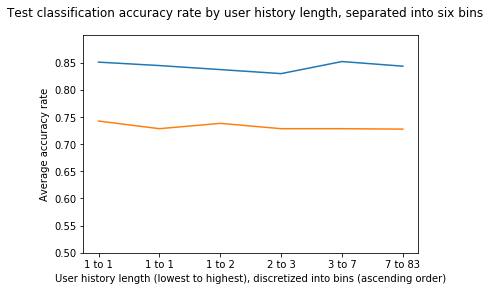

Strating ************************************************* 4
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.496
[1,   400] loss: 0.372
[1,   600] loss: 0.316
[1,   800] loss: 0.405
[1,  1000] loss: 0.351
[1,  1200] loss: 0.357
[1,  1400] loss: 0.349
[1,  1600] loss: 0.328
[1,  1800] loss: 0.339
[1,  2000] loss: 0.410
[1,  2200] loss: 0.299
[1,  2400] loss: 0.357
[1,  2600] loss: 0.379
[1,  2800] loss: 0.385
[1,  3000] loss: 0.375
[1,  3200] loss: 0.376
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.274
[2,   400] loss: 0.335
[2,   600] loss: 0.259
[2,   800] loss: 0.262
[2,  1000] loss: 0.365
[2,  1200] loss: 0.252
[2,  1400] loss: 0.295
[2,  1600] loss: 0.238
[2,  1800] loss: 0.204
[2,  2000] loss: 0.315
[2,  2200] loss: 0.207
[2,  2400] loss: 0.256
[2,  2600] loss: 0.247
[2,  2800] loss: 0.213
[2,  3000] loss: 0.292
[2,  3200] loss: 0.294
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.270
[3,   400] loss: 0.212
[3,   600] loss:

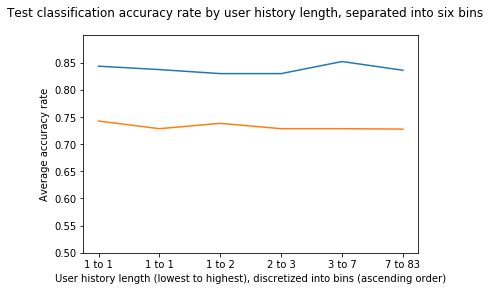

Strating ************************************************* 5
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.485
[1,   400] loss: 0.370
[1,   600] loss: 0.314
[1,   800] loss: 0.403
[1,  1000] loss: 0.354
[1,  1200] loss: 0.356
[1,  1400] loss: 0.351
[1,  1600] loss: 0.330
[1,  1800] loss: 0.337
[1,  2000] loss: 0.407
[1,  2200] loss: 0.303
[1,  2400] loss: 0.359
[1,  2600] loss: 0.379
[1,  2800] loss: 0.386
[1,  3000] loss: 0.371
[1,  3200] loss: 0.377
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.271
[2,   400] loss: 0.331
[2,   600] loss: 0.253
[2,   800] loss: 0.261
[2,  1000] loss: 0.360
[2,  1200] loss: 0.250
[2,  1400] loss: 0.291
[2,  1600] loss: 0.235
[2,  1800] loss: 0.202
[2,  2000] loss: 0.314
[2,  2200] loss: 0.202
[2,  2400] loss: 0.258
[2,  2600] loss: 0.246
[2,  2800] loss: 0.211
[2,  3000] loss: 0.290
[2,  3200] loss: 0.296
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.269
[3,   400] loss: 0.213
[3,   600] loss:

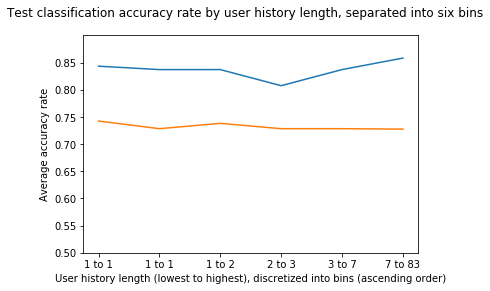

Strating ************************************************* 6
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.489
[1,   400] loss: 0.376
[1,   600] loss: 0.317
[1,   800] loss: 0.403
[1,  1000] loss: 0.352
[1,  1200] loss: 0.355
[1,  1400] loss: 0.348
[1,  1600] loss: 0.333
[1,  1800] loss: 0.336
[1,  2000] loss: 0.406
[1,  2200] loss: 0.305
[1,  2400] loss: 0.356
[1,  2600] loss: 0.377
[1,  2800] loss: 0.386
[1,  3000] loss: 0.367
[1,  3200] loss: 0.373
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.274
[2,   400] loss: 0.329
[2,   600] loss: 0.258
[2,   800] loss: 0.260
[2,  1000] loss: 0.365
[2,  1200] loss: 0.253
[2,  1400] loss: 0.295
[2,  1600] loss: 0.239
[2,  1800] loss: 0.205
[2,  2000] loss: 0.310
[2,  2200] loss: 0.204
[2,  2400] loss: 0.257
[2,  2600] loss: 0.246
[2,  2800] loss: 0.211
[2,  3000] loss: 0.286
[2,  3200] loss: 0.296
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.269
[3,   400] loss: 0.212
[3,   600] loss:

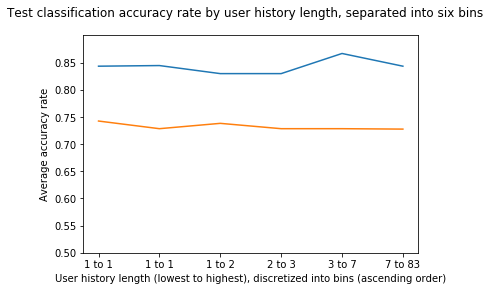

Strating ************************************************* 7
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.488
[1,   400] loss: 0.371
[1,   600] loss: 0.316
[1,   800] loss: 0.404
[1,  1000] loss: 0.351
[1,  1200] loss: 0.357
[1,  1400] loss: 0.348
[1,  1600] loss: 0.331
[1,  1800] loss: 0.336
[1,  2000] loss: 0.408
[1,  2200] loss: 0.302
[1,  2400] loss: 0.356
[1,  2600] loss: 0.380
[1,  2800] loss: 0.385
[1,  3000] loss: 0.371
[1,  3200] loss: 0.376
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.271
[2,   400] loss: 0.334
[2,   600] loss: 0.255
[2,   800] loss: 0.261
[2,  1000] loss: 0.357
[2,  1200] loss: 0.251
[2,  1400] loss: 0.292
[2,  1600] loss: 0.239
[2,  1800] loss: 0.203
[2,  2000] loss: 0.313
[2,  2200] loss: 0.201
[2,  2400] loss: 0.258
[2,  2600] loss: 0.248
[2,  2800] loss: 0.209
[2,  3000] loss: 0.292
[2,  3200] loss: 0.300
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.270
[3,   400] loss: 0.211
[3,   600] loss:

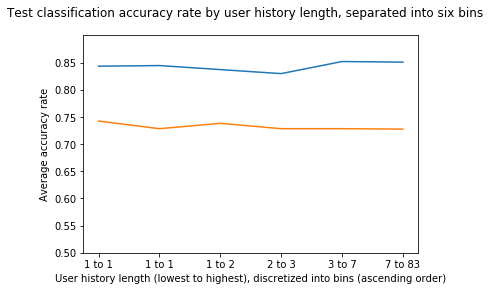

Strating ************************************************* 8
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.489
[1,   400] loss: 0.372
[1,   600] loss: 0.317
[1,   800] loss: 0.407
[1,  1000] loss: 0.352
[1,  1200] loss: 0.357
[1,  1400] loss: 0.351
[1,  1600] loss: 0.333
[1,  1800] loss: 0.334
[1,  2000] loss: 0.409
[1,  2200] loss: 0.300
[1,  2400] loss: 0.366
[1,  2600] loss: 0.377
[1,  2800] loss: 0.385
[1,  3000] loss: 0.374
[1,  3200] loss: 0.374
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.271
[2,   400] loss: 0.336
[2,   600] loss: 0.253
[2,   800] loss: 0.260
[2,  1000] loss: 0.364
[2,  1200] loss: 0.253
[2,  1400] loss: 0.295
[2,  1600] loss: 0.239
[2,  1800] loss: 0.202
[2,  2000] loss: 0.315
[2,  2200] loss: 0.205
[2,  2400] loss: 0.260
[2,  2600] loss: 0.248
[2,  2800] loss: 0.209
[2,  3000] loss: 0.291
[2,  3200] loss: 0.296
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.271
[3,   400] loss: 0.213
[3,   600] loss:

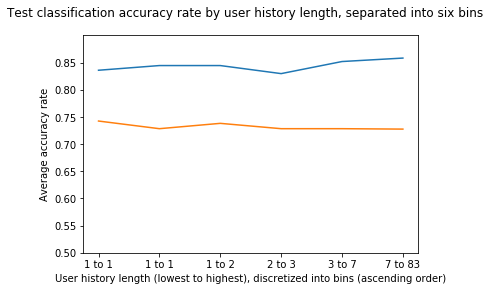

Strating ************************************************* 9
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.487
[1,   400] loss: 0.370
[1,   600] loss: 0.315
[1,   800] loss: 0.405
[1,  1000] loss: 0.353
[1,  1200] loss: 0.355
[1,  1400] loss: 0.350
[1,  1600] loss: 0.328
[1,  1800] loss: 0.335
[1,  2000] loss: 0.409
[1,  2200] loss: 0.302
[1,  2400] loss: 0.358
[1,  2600] loss: 0.375
[1,  2800] loss: 0.388
[1,  3000] loss: 0.370
[1,  3200] loss: 0.373
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.268
[2,   400] loss: 0.335
[2,   600] loss: 0.257
[2,   800] loss: 0.257
[2,  1000] loss: 0.362
[2,  1200] loss: 0.251
[2,  1400] loss: 0.294
[2,  1600] loss: 0.237
[2,  1800] loss: 0.200
[2,  2000] loss: 0.313
[2,  2200] loss: 0.200
[2,  2400] loss: 0.260
[2,  2600] loss: 0.246
[2,  2800] loss: 0.211
[2,  3000] loss: 0.288
[2,  3200] loss: 0.298
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.268
[3,   400] loss: 0.216
[3,   600] loss:

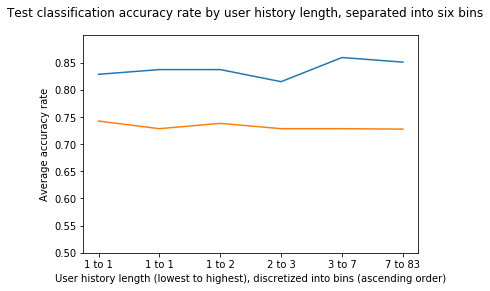

Strating ************************************************* 10
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.491
[1,   400] loss: 0.369
[1,   600] loss: 0.316
[1,   800] loss: 0.404
[1,  1000] loss: 0.353
[1,  1200] loss: 0.358
[1,  1400] loss: 0.352
[1,  1600] loss: 0.330
[1,  1800] loss: 0.336
[1,  2000] loss: 0.410
[1,  2200] loss: 0.303
[1,  2400] loss: 0.355
[1,  2600] loss: 0.381
[1,  2800] loss: 0.387
[1,  3000] loss: 0.370
[1,  3200] loss: 0.376
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.274
[2,   400] loss: 0.336
[2,   600] loss: 0.255
[2,   800] loss: 0.258
[2,  1000] loss: 0.364
[2,  1200] loss: 0.254
[2,  1400] loss: 0.293
[2,  1600] loss: 0.238
[2,  1800] loss: 0.207
[2,  2000] loss: 0.317
[2,  2200] loss: 0.203
[2,  2400] loss: 0.261
[2,  2600] loss: 0.250
[2,  2800] loss: 0.211
[2,  3000] loss: 0.291
[2,  3200] loss: 0.298
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.268
[3,   400] loss: 0.219
[3,   600] loss

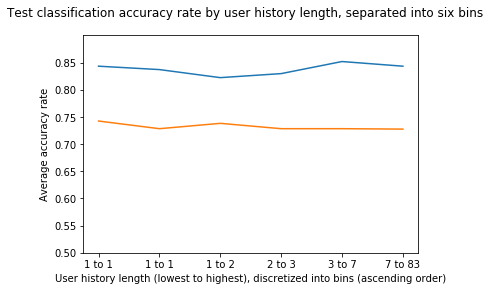

Strating ************************************************* 11
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.493
[1,   400] loss: 0.371
[1,   600] loss: 0.315
[1,   800] loss: 0.401
[1,  1000] loss: 0.351
[1,  1200] loss: 0.354
[1,  1400] loss: 0.349
[1,  1600] loss: 0.330
[1,  1800] loss: 0.338
[1,  2000] loss: 0.407
[1,  2200] loss: 0.303
[1,  2400] loss: 0.359
[1,  2600] loss: 0.375
[1,  2800] loss: 0.390
[1,  3000] loss: 0.373
[1,  3200] loss: 0.376
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.270
[2,   400] loss: 0.333
[2,   600] loss: 0.256
[2,   800] loss: 0.257
[2,  1000] loss: 0.360
[2,  1200] loss: 0.253
[2,  1400] loss: 0.297
[2,  1600] loss: 0.237
[2,  1800] loss: 0.206
[2,  2000] loss: 0.312
[2,  2200] loss: 0.202
[2,  2400] loss: 0.260
[2,  2600] loss: 0.245
[2,  2800] loss: 0.211
[2,  3000] loss: 0.290
[2,  3200] loss: 0.297
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.267
[3,   400] loss: 0.214
[3,   600] loss

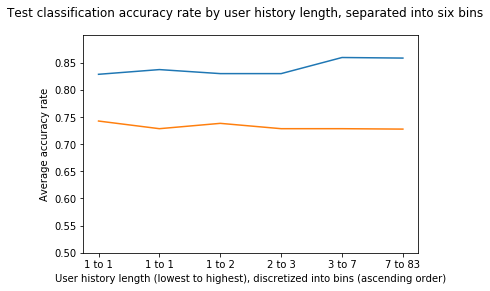

Strating ************************************************* 12
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.488
[1,   400] loss: 0.377
[1,   600] loss: 0.319
[1,   800] loss: 0.403
[1,  1000] loss: 0.353
[1,  1200] loss: 0.360
[1,  1400] loss: 0.348
[1,  1600] loss: 0.330
[1,  1800] loss: 0.336
[1,  2000] loss: 0.409
[1,  2200] loss: 0.304
[1,  2400] loss: 0.360
[1,  2600] loss: 0.375
[1,  2800] loss: 0.390
[1,  3000] loss: 0.373
[1,  3200] loss: 0.375
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.271
[2,   400] loss: 0.333
[2,   600] loss: 0.257
[2,   800] loss: 0.261
[2,  1000] loss: 0.363
[2,  1200] loss: 0.254
[2,  1400] loss: 0.293
[2,  1600] loss: 0.238
[2,  1800] loss: 0.203
[2,  2000] loss: 0.316
[2,  2200] loss: 0.204
[2,  2400] loss: 0.258
[2,  2600] loss: 0.247
[2,  2800] loss: 0.214
[2,  3000] loss: 0.293
[2,  3200] loss: 0.298
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.268
[3,   400] loss: 0.214
[3,   600] loss

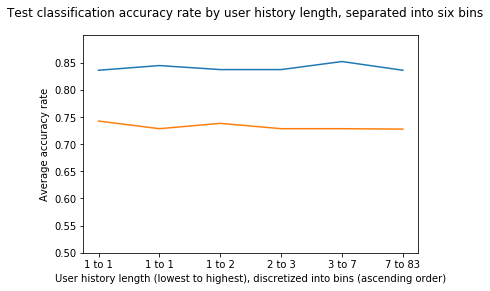

Strating ************************************************* 13
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.493
[1,   400] loss: 0.366
[1,   600] loss: 0.314
[1,   800] loss: 0.402
[1,  1000] loss: 0.353
[1,  1200] loss: 0.356
[1,  1400] loss: 0.350
[1,  1600] loss: 0.331
[1,  1800] loss: 0.335
[1,  2000] loss: 0.405
[1,  2200] loss: 0.302
[1,  2400] loss: 0.355
[1,  2600] loss: 0.378
[1,  2800] loss: 0.386
[1,  3000] loss: 0.373
[1,  3200] loss: 0.375
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.272
[2,   400] loss: 0.332
[2,   600] loss: 0.254
[2,   800] loss: 0.259
[2,  1000] loss: 0.362
[2,  1200] loss: 0.253
[2,  1400] loss: 0.292
[2,  1600] loss: 0.235
[2,  1800] loss: 0.206
[2,  2000] loss: 0.313
[2,  2200] loss: 0.200
[2,  2400] loss: 0.257
[2,  2600] loss: 0.246
[2,  2800] loss: 0.212
[2,  3000] loss: 0.287
[2,  3200] loss: 0.297
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.268
[3,   400] loss: 0.213
[3,   600] loss

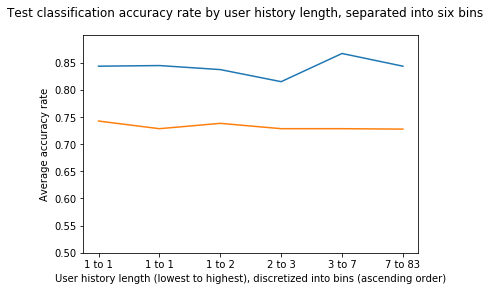

Strating ************************************************* 14
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.488
[1,   400] loss: 0.374
[1,   600] loss: 0.313
[1,   800] loss: 0.404
[1,  1000] loss: 0.351
[1,  1200] loss: 0.358
[1,  1400] loss: 0.349
[1,  1600] loss: 0.335
[1,  1800] loss: 0.334
[1,  2000] loss: 0.408
[1,  2200] loss: 0.302
[1,  2400] loss: 0.360
[1,  2600] loss: 0.378
[1,  2800] loss: 0.385
[1,  3000] loss: 0.372
[1,  3200] loss: 0.373
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.269
[2,   400] loss: 0.334
[2,   600] loss: 0.254
[2,   800] loss: 0.261
[2,  1000] loss: 0.357
[2,  1200] loss: 0.250
[2,  1400] loss: 0.292
[2,  1600] loss: 0.235
[2,  1800] loss: 0.203
[2,  2000] loss: 0.311
[2,  2200] loss: 0.202
[2,  2400] loss: 0.256
[2,  2600] loss: 0.247
[2,  2800] loss: 0.211
[2,  3000] loss: 0.287
[2,  3200] loss: 0.293
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.265
[3,   400] loss: 0.212
[3,   600] loss

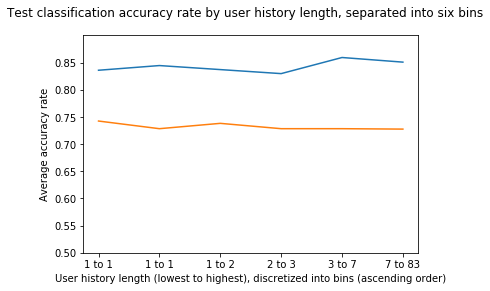

Strating ************************************************* 15
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.493
[1,   400] loss: 0.373
[1,   600] loss: 0.315
[1,   800] loss: 0.405
[1,  1000] loss: 0.352
[1,  1200] loss: 0.358
[1,  1400] loss: 0.348
[1,  1600] loss: 0.330
[1,  1800] loss: 0.333
[1,  2000] loss: 0.409
[1,  2200] loss: 0.301
[1,  2400] loss: 0.361
[1,  2600] loss: 0.378
[1,  2800] loss: 0.387
[1,  3000] loss: 0.370
[1,  3200] loss: 0.376
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.272
[2,   400] loss: 0.331
[2,   600] loss: 0.254
[2,   800] loss: 0.261
[2,  1000] loss: 0.359
[2,  1200] loss: 0.253
[2,  1400] loss: 0.294
[2,  1600] loss: 0.234
[2,  1800] loss: 0.202
[2,  2000] loss: 0.314
[2,  2200] loss: 0.204
[2,  2400] loss: 0.257
[2,  2600] loss: 0.247
[2,  2800] loss: 0.208
[2,  3000] loss: 0.284
[2,  3200] loss: 0.299
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.270
[3,   400] loss: 0.212
[3,   600] loss

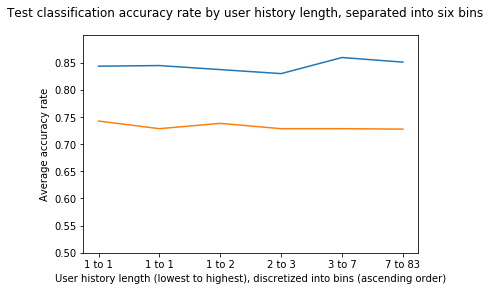

Strating ************************************************* 16
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.494
[1,   400] loss: 0.374
[1,   600] loss: 0.317
[1,   800] loss: 0.406
[1,  1000] loss: 0.351
[1,  1200] loss: 0.360
[1,  1400] loss: 0.350
[1,  1600] loss: 0.332
[1,  1800] loss: 0.338
[1,  2000] loss: 0.401
[1,  2200] loss: 0.304
[1,  2400] loss: 0.356
[1,  2600] loss: 0.377
[1,  2800] loss: 0.389
[1,  3000] loss: 0.375
[1,  3200] loss: 0.375
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.275
[2,   400] loss: 0.337
[2,   600] loss: 0.258
[2,   800] loss: 0.261
[2,  1000] loss: 0.363
[2,  1200] loss: 0.251
[2,  1400] loss: 0.296
[2,  1600] loss: 0.237
[2,  1800] loss: 0.205
[2,  2000] loss: 0.314
[2,  2200] loss: 0.206
[2,  2400] loss: 0.258
[2,  2600] loss: 0.252
[2,  2800] loss: 0.213
[2,  3000] loss: 0.292
[2,  3200] loss: 0.297
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.269
[3,   400] loss: 0.219
[3,   600] loss

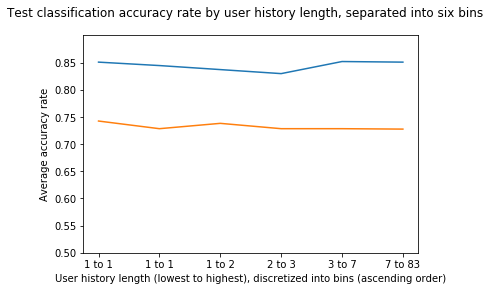

Strating ************************************************* 17
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.491
[1,   400] loss: 0.369
[1,   600] loss: 0.315
[1,   800] loss: 0.405
[1,  1000] loss: 0.354
[1,  1200] loss: 0.355
[1,  1400] loss: 0.346
[1,  1600] loss: 0.331
[1,  1800] loss: 0.341
[1,  2000] loss: 0.408
[1,  2200] loss: 0.302
[1,  2400] loss: 0.356
[1,  2600] loss: 0.375
[1,  2800] loss: 0.384
[1,  3000] loss: 0.374
[1,  3200] loss: 0.374
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.269
[2,   400] loss: 0.332
[2,   600] loss: 0.256
[2,   800] loss: 0.259
[2,  1000] loss: 0.364
[2,  1200] loss: 0.248
[2,  1400] loss: 0.289
[2,  1600] loss: 0.236
[2,  1800] loss: 0.204
[2,  2000] loss: 0.314
[2,  2200] loss: 0.202
[2,  2400] loss: 0.257
[2,  2600] loss: 0.245
[2,  2800] loss: 0.211
[2,  3000] loss: 0.295
[2,  3200] loss: 0.293
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.267
[3,   400] loss: 0.215
[3,   600] loss

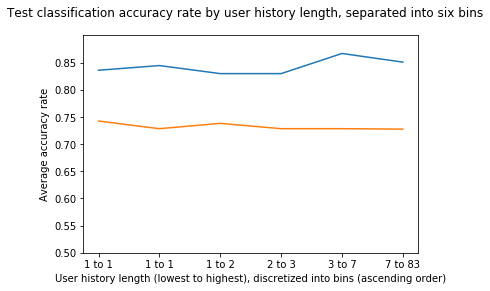

Strating ************************************************* 18
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.491
[1,   400] loss: 0.376
[1,   600] loss: 0.318
[1,   800] loss: 0.404
[1,  1000] loss: 0.352
[1,  1200] loss: 0.361
[1,  1400] loss: 0.348
[1,  1600] loss: 0.330
[1,  1800] loss: 0.338
[1,  2000] loss: 0.403
[1,  2200] loss: 0.305
[1,  2400] loss: 0.356
[1,  2600] loss: 0.374
[1,  2800] loss: 0.388
[1,  3000] loss: 0.371
[1,  3200] loss: 0.378
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.270
[2,   400] loss: 0.330
[2,   600] loss: 0.259
[2,   800] loss: 0.264
[2,  1000] loss: 0.366
[2,  1200] loss: 0.254
[2,  1400] loss: 0.297
[2,  1600] loss: 0.238
[2,  1800] loss: 0.204
[2,  2000] loss: 0.319
[2,  2200] loss: 0.204
[2,  2400] loss: 0.261
[2,  2600] loss: 0.247
[2,  2800] loss: 0.209
[2,  3000] loss: 0.289
[2,  3200] loss: 0.297
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.273
[3,   400] loss: 0.215
[3,   600] loss

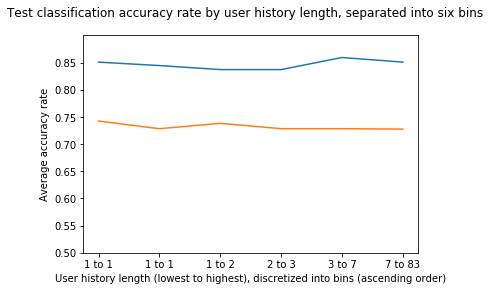

Strating ************************************************* 19
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.492
[1,   400] loss: 0.374
[1,   600] loss: 0.314
[1,   800] loss: 0.404
[1,  1000] loss: 0.353
[1,  1200] loss: 0.354
[1,  1400] loss: 0.346
[1,  1600] loss: 0.328
[1,  1800] loss: 0.340
[1,  2000] loss: 0.405
[1,  2200] loss: 0.304
[1,  2400] loss: 0.356
[1,  2600] loss: 0.378
[1,  2800] loss: 0.388
[1,  3000] loss: 0.375
[1,  3200] loss: 0.374
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.275
[2,   400] loss: 0.332
[2,   600] loss: 0.257
[2,   800] loss: 0.258
[2,  1000] loss: 0.364
[2,  1200] loss: 0.251
[2,  1400] loss: 0.294
[2,  1600] loss: 0.238
[2,  1800] loss: 0.204
[2,  2000] loss: 0.314
[2,  2200] loss: 0.202
[2,  2400] loss: 0.261
[2,  2600] loss: 0.248
[2,  2800] loss: 0.213
[2,  3000] loss: 0.291
[2,  3200] loss: 0.297
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.267
[3,   400] loss: 0.215
[3,   600] loss

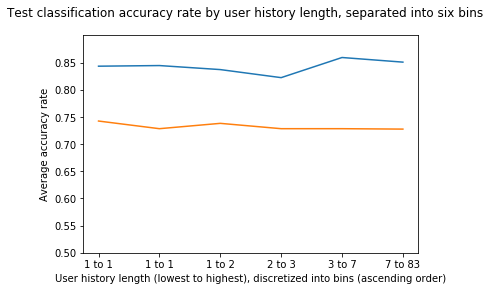

Strating ************************************************* 20
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.490
[1,   400] loss: 0.376
[1,   600] loss: 0.312
[1,   800] loss: 0.404
[1,  1000] loss: 0.352
[1,  1200] loss: 0.357
[1,  1400] loss: 0.347
[1,  1600] loss: 0.330
[1,  1800] loss: 0.336
[1,  2000] loss: 0.408
[1,  2200] loss: 0.302
[1,  2400] loss: 0.359
[1,  2600] loss: 0.375
[1,  2800] loss: 0.388
[1,  3000] loss: 0.373
[1,  3200] loss: 0.373
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.270
[2,   400] loss: 0.332
[2,   600] loss: 0.255
[2,   800] loss: 0.258
[2,  1000] loss: 0.360
[2,  1200] loss: 0.253
[2,  1400] loss: 0.291
[2,  1600] loss: 0.236
[2,  1800] loss: 0.201
[2,  2000] loss: 0.315
[2,  2200] loss: 0.203
[2,  2400] loss: 0.257
[2,  2600] loss: 0.247
[2,  2800] loss: 0.211
[2,  3000] loss: 0.289
[2,  3200] loss: 0.291
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.266
[3,   400] loss: 0.213
[3,   600] loss

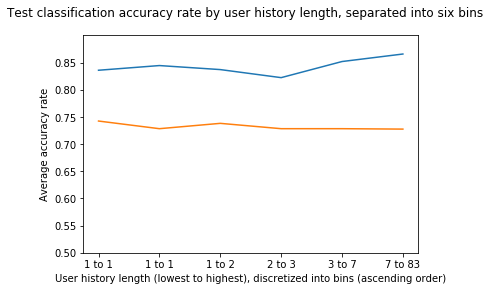

Strating ************************************************* 21
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.489
[1,   400] loss: 0.374
[1,   600] loss: 0.318
[1,   800] loss: 0.403
[1,  1000] loss: 0.350
[1,  1200] loss: 0.362
[1,  1400] loss: 0.350
[1,  1600] loss: 0.330
[1,  1800] loss: 0.335
[1,  2000] loss: 0.407
[1,  2200] loss: 0.302
[1,  2400] loss: 0.353
[1,  2600] loss: 0.381
[1,  2800] loss: 0.390
[1,  3000] loss: 0.371
[1,  3200] loss: 0.376
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.272
[2,   400] loss: 0.335
[2,   600] loss: 0.255
[2,   800] loss: 0.261
[2,  1000] loss: 0.361
[2,  1200] loss: 0.255
[2,  1400] loss: 0.294
[2,  1600] loss: 0.237
[2,  1800] loss: 0.202
[2,  2000] loss: 0.311
[2,  2200] loss: 0.203
[2,  2400] loss: 0.258
[2,  2600] loss: 0.244
[2,  2800] loss: 0.211
[2,  3000] loss: 0.285
[2,  3200] loss: 0.296
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.267
[3,   400] loss: 0.215
[3,   600] loss

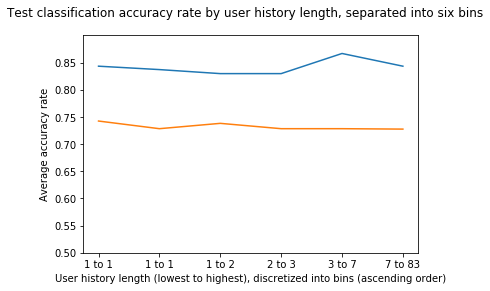

Strating ************************************************* 22
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.490
[1,   400] loss: 0.374
[1,   600] loss: 0.316
[1,   800] loss: 0.404
[1,  1000] loss: 0.351
[1,  1200] loss: 0.361
[1,  1400] loss: 0.350
[1,  1600] loss: 0.328
[1,  1800] loss: 0.336
[1,  2000] loss: 0.413
[1,  2200] loss: 0.301
[1,  2400] loss: 0.355
[1,  2600] loss: 0.379
[1,  2800] loss: 0.390
[1,  3000] loss: 0.372
[1,  3200] loss: 0.374
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.274
[2,   400] loss: 0.334
[2,   600] loss: 0.253
[2,   800] loss: 0.259
[2,  1000] loss: 0.360
[2,  1200] loss: 0.254
[2,  1400] loss: 0.295
[2,  1600] loss: 0.236
[2,  1800] loss: 0.205
[2,  2000] loss: 0.315
[2,  2200] loss: 0.205
[2,  2400] loss: 0.259
[2,  2600] loss: 0.250
[2,  2800] loss: 0.211
[2,  3000] loss: 0.292
[2,  3200] loss: 0.299
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.268
[3,   400] loss: 0.214
[3,   600] loss

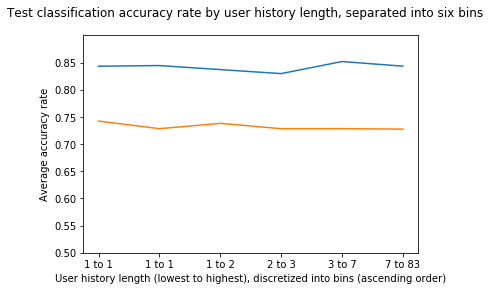

Strating ************************************************* 23
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.489
[1,   400] loss: 0.372
[1,   600] loss: 0.316
[1,   800] loss: 0.400
[1,  1000] loss: 0.353
[1,  1200] loss: 0.357
[1,  1400] loss: 0.350
[1,  1600] loss: 0.327
[1,  1800] loss: 0.338
[1,  2000] loss: 0.402
[1,  2200] loss: 0.304
[1,  2400] loss: 0.358
[1,  2600] loss: 0.375
[1,  2800] loss: 0.386
[1,  3000] loss: 0.371
[1,  3200] loss: 0.376
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.271
[2,   400] loss: 0.331
[2,   600] loss: 0.254
[2,   800] loss: 0.262
[2,  1000] loss: 0.363
[2,  1200] loss: 0.252
[2,  1400] loss: 0.293
[2,  1600] loss: 0.238
[2,  1800] loss: 0.202
[2,  2000] loss: 0.312
[2,  2200] loss: 0.201
[2,  2400] loss: 0.253
[2,  2600] loss: 0.251
[2,  2800] loss: 0.210
[2,  3000] loss: 0.287
[2,  3200] loss: 0.296
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.269
[3,   400] loss: 0.213
[3,   600] loss

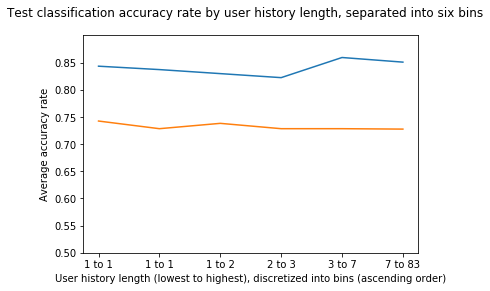

Strating ************************************************* 24
epoch: 0 learning rate: [0.011715295017547324]
[1,   200] loss: 0.489
[1,   400] loss: 0.374
[1,   600] loss: 0.313
[1,   800] loss: 0.402
[1,  1000] loss: 0.351
[1,  1200] loss: 0.358
[1,  1400] loss: 0.346
[1,  1600] loss: 0.330
[1,  1800] loss: 0.336
[1,  2000] loss: 0.405
[1,  2200] loss: 0.305
[1,  2400] loss: 0.356
[1,  2600] loss: 0.373
[1,  2800] loss: 0.387
[1,  3000] loss: 0.373
[1,  3200] loss: 0.375
epoch: 1 learning rate: [0.00135722403582209]
[2,   200] loss: 0.270
[2,   400] loss: 0.326
[2,   600] loss: 0.253
[2,   800] loss: 0.257
[2,  1000] loss: 0.360
[2,  1200] loss: 0.248
[2,  1400] loss: 0.290
[2,  1600] loss: 0.235
[2,  1800] loss: 0.203
[2,  2000] loss: 0.313
[2,  2200] loss: 0.198
[2,  2400] loss: 0.255
[2,  2600] loss: 0.244
[2,  2800] loss: 0.212
[2,  3000] loss: 0.287
[2,  3200] loss: 0.297
epoch: 2 learning rate: [0.0001572352280206469]
[3,   200] loss: 0.264
[3,   400] loss: 0.208
[3,   600] loss

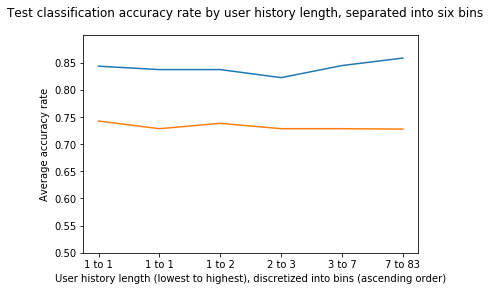

In [5]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_img_train, X_img_test)

Acc: 0.8417821782178219
AUC: 0.7911549797298109
F1: 0.9111180566138537
Precision: 0.8721200612666451
Recall: 0.9537700145560406


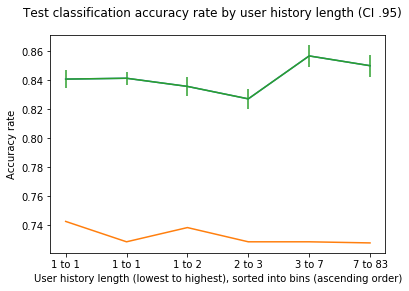

In [6]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [7]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [8]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'history_baseline_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [9]:
# retieve test data history sequence lengths from LSTM data
X_hist_len_test = np.load(NPY_INPUT_DIR + 'full_hist_lens_test.npy')

# class labels
y_train = np.load(GLOVE_DIR + 'y_train.npy')
y_test= np.load(GLOVE_DIR + 'y_test.npy')

# load features
# img
X_histories_train_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_train.npy')
X_histories_test_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_test.npy')

X_labeled_train_img = np.load(NPY_INPUT_DIR + 'images_nohistories_train.npy')
X_labeled_test_img = np.load(NPY_INPUT_DIR + 'images_nohistories_test.npy')

# lang
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')



X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')


scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

scaler5 = StandardScaler()
scaler6 = StandardScaler()


X_histories_train_img_norm = scaler5.fit_transform(X_histories_train_img)
X_histories_test_img_norm  = scaler5.transform(X_histories_test_img)
X_labeled_train_img_norm = scaler5.fit_transform(X_labeled_train_img)
X_labeled_test_img_norm  = scaler5.transform(X_labeled_test_img)
        
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)


Strating ************************************************* 0
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.439
[1,   400] loss: 0.369
[1,   600] loss: 0.346
[1,   800] loss: 0.373
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.272
[2,   400] loss: 0.285
[2,   600] loss: 0.259
[2,   800] loss: 0.281
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.256
[3,   400] loss: 0.236
[3,   600] loss: 0.256
[3,   800] loss: 0.240
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.256
[4,   400] loss: 0.231
[4,   600] loss: 0.245
[4,   800] loss: 0.248
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.41891891891891886
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proporti

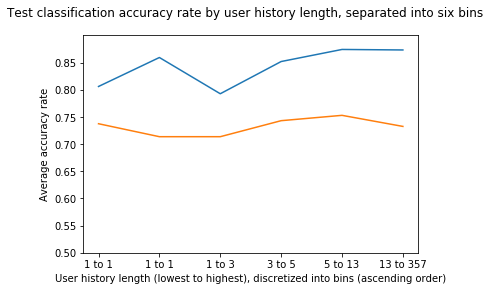

Strating ************************************************* 1
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.463
[1,   400] loss: 0.348
[1,   600] loss: 0.359
[1,   800] loss: 0.348
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.281
[2,   400] loss: 0.266
[2,   600] loss: 0.268
[2,   800] loss: 0.263
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.264
[3,   400] loss: 0.264
[3,   600] loss: 0.244
[3,   800] loss: 0.211
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.239
[4,   400] loss: 0.264
[4,   600] loss: 0.230
[4,   800] loss: 0.239
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion

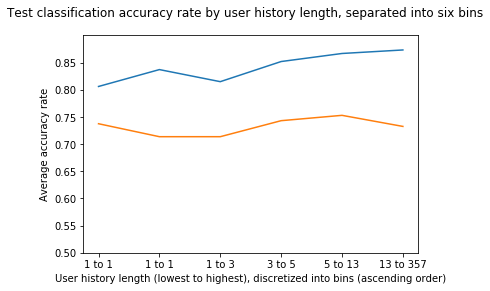

Strating ************************************************* 2
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.449
[1,   400] loss: 0.362
[1,   600] loss: 0.376
[1,   800] loss: 0.328
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.272
[2,   400] loss: 0.249
[2,   600] loss: 0.267
[2,   800] loss: 0.266
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.226
[3,   400] loss: 0.245
[3,   600] loss: 0.254
[3,   800] loss: 0.242
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.239
[4,   400] loss: 0.249
[4,   600] loss: 0.242
[4,   800] loss: 0.223
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proport

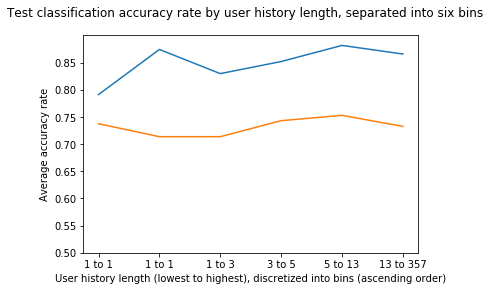

Strating ************************************************* 3
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.445
[1,   400] loss: 0.396
[1,   600] loss: 0.323
[1,   800] loss: 0.334
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.285
[2,   400] loss: 0.281
[2,   600] loss: 0.261
[2,   800] loss: 0.286
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.243
[3,   400] loss: 0.276
[3,   600] loss: 0.252
[3,   800] loss: 0.250
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.295
[4,   400] loss: 0.216
[4,   600] loss: 0.236
[4,   800] loss: 0.263
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proport

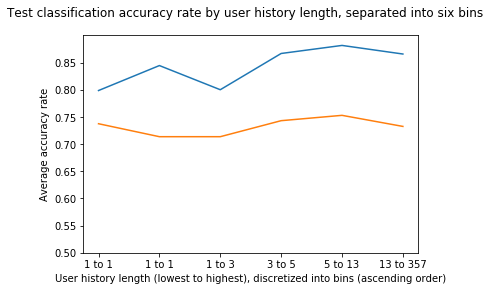

Strating ************************************************* 4
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.439
[1,   400] loss: 0.357
[1,   600] loss: 0.347
[1,   800] loss: 0.352
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.292
[2,   400] loss: 0.256
[2,   600] loss: 0.269
[2,   800] loss: 0.263
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.242
[3,   400] loss: 0.269
[3,   600] loss: 0.240
[3,   800] loss: 0.248
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.254
[4,   400] loss: 0.262
[4,   600] loss: 0.227
[4,   800] loss: 0.236
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

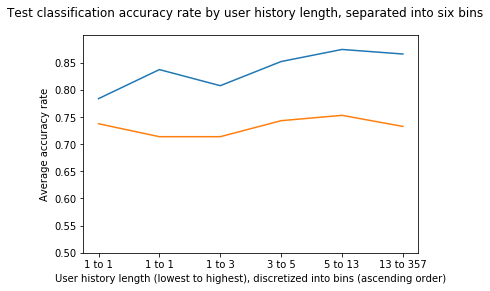

Strating ************************************************* 5
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.438
[1,   400] loss: 0.337
[1,   600] loss: 0.377
[1,   800] loss: 0.373
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.292
[2,   400] loss: 0.262
[2,   600] loss: 0.286
[2,   800] loss: 0.247
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.255
[3,   400] loss: 0.237
[3,   600] loss: 0.237
[3,   800] loss: 0.237
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.230
[4,   400] loss: 0.250
[4,   600] loss: 0.238
[4,   800] loss: 0.227
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

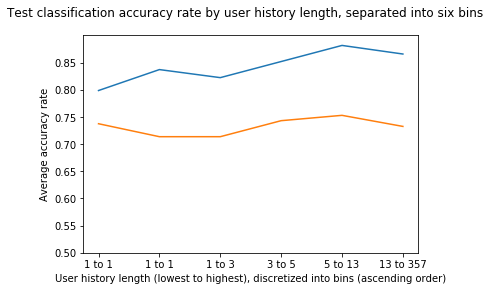

Strating ************************************************* 6
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.422
[1,   400] loss: 0.387
[1,   600] loss: 0.348
[1,   800] loss: 0.347
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.310
[2,   400] loss: 0.259
[2,   600] loss: 0.260
[2,   800] loss: 0.273
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.254
[3,   400] loss: 0.238
[3,   600] loss: 0.251
[3,   800] loss: 0.253
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.226
[4,   400] loss: 0.290
[4,   600] loss: 0.225
[4,   800] loss: 0.241
R2 score for bin 0 = -0.3491990846681925
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

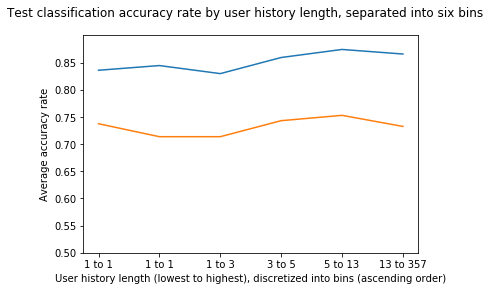

Strating ************************************************* 7
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.426
[1,   400] loss: 0.367
[1,   600] loss: 0.383
[1,   800] loss: 0.344
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.269
[2,   400] loss: 0.277
[2,   600] loss: 0.244
[2,   800] loss: 0.247
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.240
[3,   400] loss: 0.238
[3,   600] loss: 0.236
[3,   800] loss: 0.232
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.249
[4,   400] loss: 0.210
[4,   600] loss: 0.216
[4,   800] loss: 0.255
R2 score for bin 0 = -0.9011441647597258
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.059649122807017174
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proporti

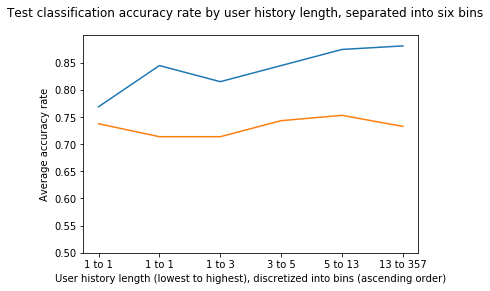

Strating ************************************************* 8
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.421
[1,   400] loss: 0.365
[1,   600] loss: 0.355
[1,   800] loss: 0.351
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.262
[2,   400] loss: 0.274
[2,   600] loss: 0.291
[2,   800] loss: 0.243
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.228
[3,   400] loss: 0.263
[3,   600] loss: 0.234
[3,   800] loss: 0.245
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.194
[4,   400] loss: 0.250
[4,   600] loss: 0.241
[4,   800] loss: 0.272
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proporti

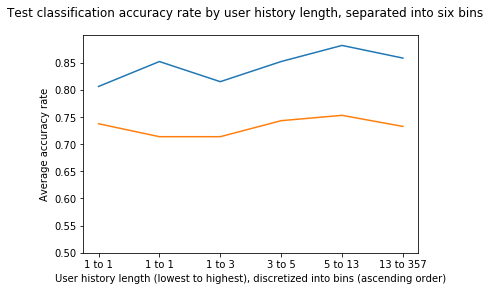

Strating ************************************************* 9
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.411
[1,   400] loss: 0.377
[1,   600] loss: 0.326
[1,   800] loss: 0.383
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.276
[2,   400] loss: 0.244
[2,   600] loss: 0.277
[2,   800] loss: 0.276
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.259
[3,   400] loss: 0.238
[3,   600] loss: 0.251
[3,   800] loss: 0.231
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.242
[4,   400] loss: 0.235
[4,   600] loss: 0.249
[4,   800] loss: 0.241
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.06355042016806745
R2 score for bin 5 = 0.059649122807017174
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportio

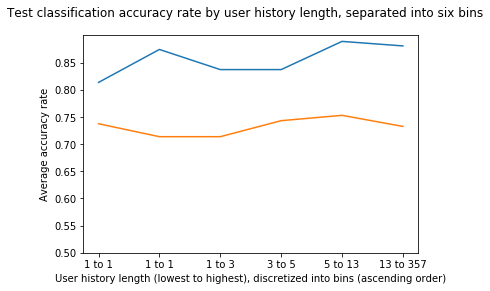

Strating ************************************************* 10
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.450
[1,   400] loss: 0.371
[1,   600] loss: 0.322
[1,   800] loss: 0.334
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.270
[2,   400] loss: 0.295
[2,   600] loss: 0.245
[2,   800] loss: 0.277
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.259
[3,   400] loss: 0.251
[3,   600] loss: 0.255
[3,   800] loss: 0.228
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.245
[4,   400] loss: 0.251
[4,   600] loss: 0.239
[4,   800] loss: 0.248
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proport

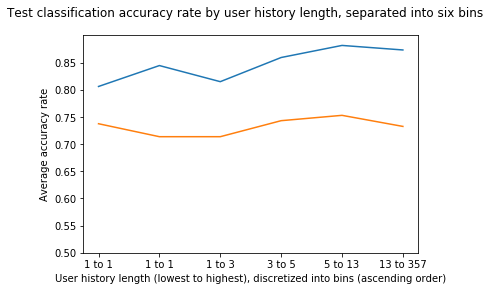

Strating ************************************************* 11
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.433
[1,   400] loss: 0.366
[1,   600] loss: 0.339
[1,   800] loss: 0.344
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.285
[2,   400] loss: 0.262
[2,   600] loss: 0.277
[2,   800] loss: 0.251
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.242
[3,   400] loss: 0.235
[3,   600] loss: 0.256
[3,   800] loss: 0.249
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.228
[4,   400] loss: 0.252
[4,   600] loss: 0.255
[4,   800] loss: 0.242
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.317567567567568
R2 score for bin 2 = -0.41891891891891886
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion 

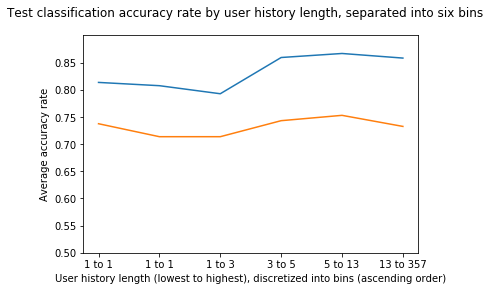

Strating ************************************************* 12
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.419
[1,   400] loss: 0.350
[1,   600] loss: 0.386
[1,   800] loss: 0.343
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.272
[2,   400] loss: 0.258
[2,   600] loss: 0.304
[2,   800] loss: 0.241
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.242
[3,   400] loss: 0.237
[3,   600] loss: 0.256
[3,   800] loss: 0.233
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.248
[4,   400] loss: 0.248
[4,   600] loss: 0.238
[4,   800] loss: 0.228
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

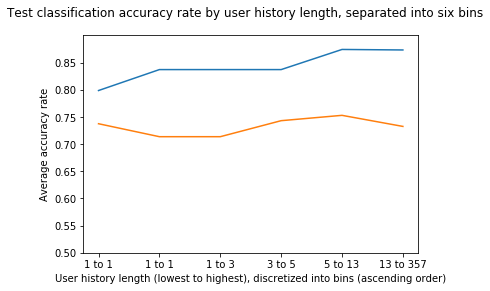

Strating ************************************************* 13
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.438
[1,   400] loss: 0.349
[1,   600] loss: 0.376
[1,   800] loss: 0.348
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.274
[2,   400] loss: 0.271
[2,   600] loss: 0.292
[2,   800] loss: 0.257
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.256
[3,   400] loss: 0.238
[3,   600] loss: 0.245
[3,   800] loss: 0.257
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.237
[4,   400] loss: 0.265
[4,   600] loss: 0.232
[4,   800] loss: 0.257
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

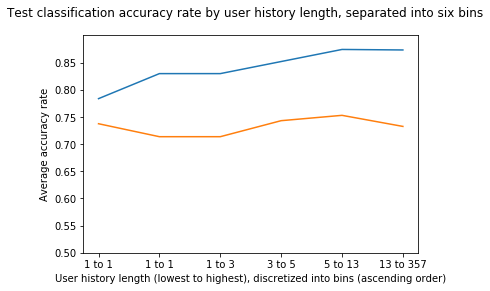

Strating ************************************************* 14
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.397
[1,   400] loss: 0.378
[1,   600] loss: 0.331
[1,   800] loss: 0.376
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.269
[2,   400] loss: 0.275
[2,   600] loss: 0.254
[2,   800] loss: 0.269
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.235
[3,   400] loss: 0.235
[3,   600] loss: 0.244
[3,   800] loss: 0.258
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.256
[4,   400] loss: 0.221
[4,   600] loss: 0.232
[4,   800] loss: 0.248
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.41891891891891886
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.059649122807017174
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

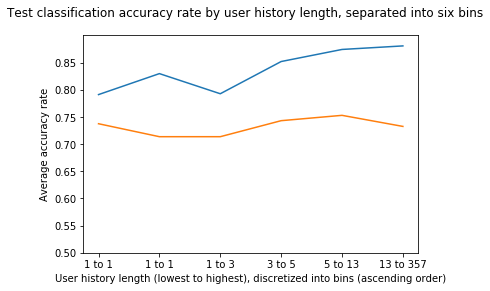

Strating ************************************************* 15
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.435
[1,   400] loss: 0.403
[1,   600] loss: 0.312
[1,   800] loss: 0.356
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.275
[2,   400] loss: 0.259
[2,   600] loss: 0.272
[2,   800] loss: 0.255
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.250
[3,   400] loss: 0.223
[3,   600] loss: 0.237
[3,   800] loss: 0.246
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.234
[4,   400] loss: 0.226
[4,   600] loss: 0.245
[4,   800] loss: 0.240
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.4695945945945945
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = 0.11842105263157854
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion 

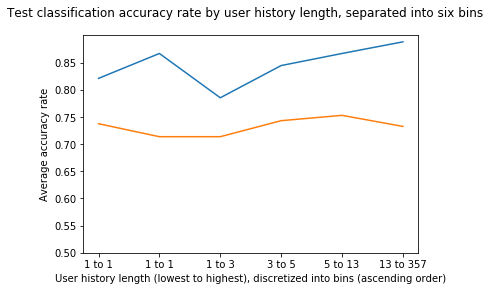

Strating ************************************************* 16
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.443
[1,   400] loss: 0.369
[1,   600] loss: 0.333
[1,   800] loss: 0.362
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.272
[2,   400] loss: 0.290
[2,   600] loss: 0.264
[2,   800] loss: 0.269
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.234
[3,   400] loss: 0.262
[3,   600] loss: 0.260
[3,   800] loss: 0.241
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.229
[4,   400] loss: 0.249
[4,   600] loss: 0.290
[4,   800] loss: 0.217
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = 0.059649122807017174
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion 

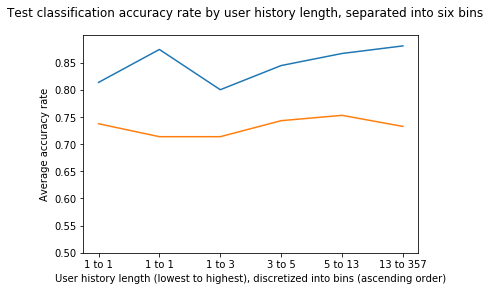

Strating ************************************************* 17
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.438
[1,   400] loss: 0.377
[1,   600] loss: 0.382
[1,   800] loss: 0.291
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.262
[2,   400] loss: 0.268
[2,   600] loss: 0.270
[2,   800] loss: 0.276
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.243
[3,   400] loss: 0.241
[3,   600] loss: 0.242
[3,   800] loss: 0.248
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.251
[4,   400] loss: 0.245
[4,   600] loss: 0.210
[4,   800] loss: 0.256
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propo

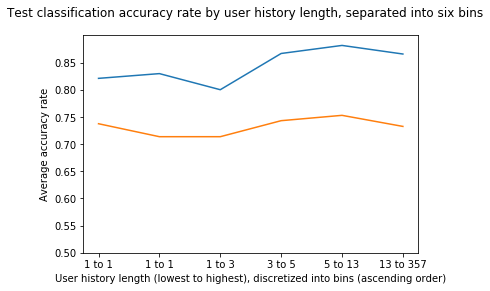

Strating ************************************************* 18
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.441
[1,   400] loss: 0.356
[1,   600] loss: 0.336
[1,   800] loss: 0.350
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.249
[2,   400] loss: 0.278
[2,   600] loss: 0.277
[2,   800] loss: 0.275
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.251
[3,   400] loss: 0.243
[3,   600] loss: 0.260
[3,   800] loss: 0.226
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.226
[4,   400] loss: 0.242
[4,   600] loss: 0.241
[4,   800] loss: 0.257
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

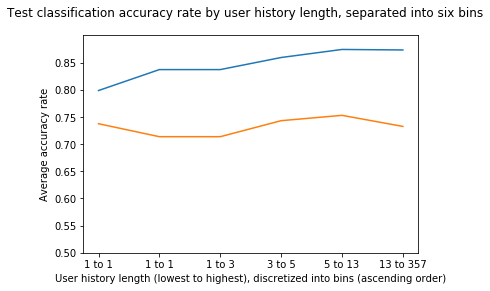

Strating ************************************************* 19
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.434
[1,   400] loss: 0.340
[1,   600] loss: 0.323
[1,   800] loss: 0.397
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.285
[2,   400] loss: 0.256
[2,   600] loss: 0.266
[2,   800] loss: 0.297
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.234
[3,   400] loss: 0.264
[3,   600] loss: 0.265
[3,   800] loss: 0.242
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.260
[4,   400] loss: 0.261
[4,   600] loss: 0.237
[4,   800] loss: 0.237
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.06355042016806745
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportio

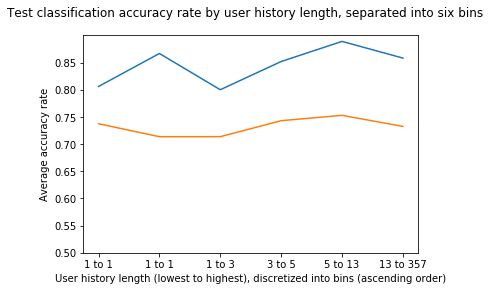

Strating ************************************************* 20
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.467
[1,   400] loss: 0.328
[1,   600] loss: 0.378
[1,   800] loss: 0.341
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.288
[2,   400] loss: 0.276
[2,   600] loss: 0.277
[2,   800] loss: 0.267
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.243
[3,   400] loss: 0.257
[3,   600] loss: 0.252
[3,   800] loss: 0.266
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.206
[4,   400] loss: 0.262
[4,   600] loss: 0.290
[4,   800] loss: 0.243
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

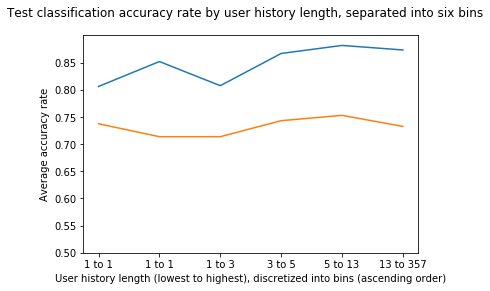

Strating ************************************************* 21
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.427
[1,   400] loss: 0.370
[1,   600] loss: 0.367
[1,   800] loss: 0.331
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.276
[2,   400] loss: 0.283
[2,   600] loss: 0.274
[2,   800] loss: 0.246
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.250
[3,   400] loss: 0.237
[3,   600] loss: 0.256
[3,   800] loss: 0.242
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.255
[4,   400] loss: 0.253
[4,   600] loss: 0.228
[4,   800] loss: 0.239
R2 score for bin 0 = -0.9011441647597258
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.06418918918918903
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = 0.059649122807017174
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True propor

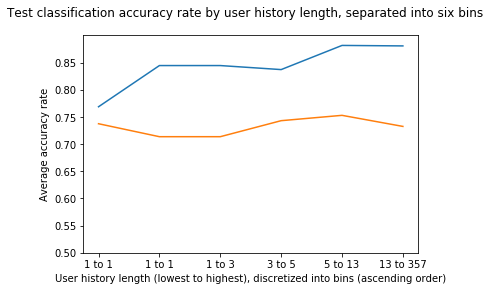

Strating ************************************************* 22
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.443
[1,   400] loss: 0.369
[1,   600] loss: 0.335
[1,   800] loss: 0.333
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.299
[2,   400] loss: 0.276
[2,   600] loss: 0.268
[2,   800] loss: 0.242
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.251
[3,   400] loss: 0.230
[3,   600] loss: 0.258
[3,   800] loss: 0.240
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.237
[4,   400] loss: 0.238
[4,   600] loss: 0.260
[4,   800] loss: 0.235
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.26689189189189233
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proport

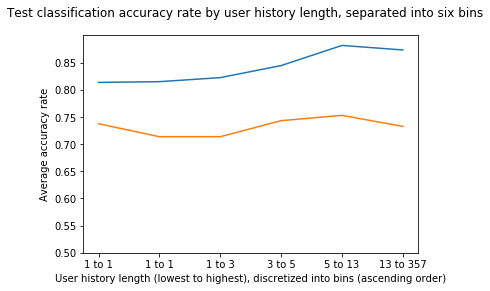

Strating ************************************************* 23
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.417
[1,   400] loss: 0.318
[1,   600] loss: 0.372
[1,   800] loss: 0.379
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.270
[2,   400] loss: 0.282
[2,   600] loss: 0.268
[2,   800] loss: 0.281
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.235
[3,   400] loss: 0.244
[3,   600] loss: 0.268
[3,   800] loss: 0.278
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.269
[4,   400] loss: 0.244
[4,   600] loss: 0.233
[4,   800] loss: 0.268
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proport

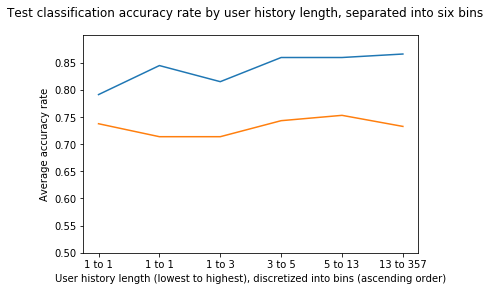

Strating ************************************************* 24
epoch: 0 learning rate: [0.018543336315269637]
[1,   200] loss: 0.409
[1,   400] loss: 0.339
[1,   600] loss: 0.368
[1,   800] loss: 0.398
epoch: 1 learning rate: [0.002014086451386551]
[2,   200] loss: 0.261
[2,   400] loss: 0.274
[2,   600] loss: 0.274
[2,   800] loss: 0.259
epoch: 2 learning rate: [0.00021876021470410806]
[3,   200] loss: 0.248
[3,   400] loss: 0.253
[3,   600] loss: 0.239
[3,   800] loss: 0.228
epoch: 3 learning rate: [2.3760664049173304e-05]
[4,   200] loss: 0.244
[4,   400] loss: 0.247
[4,   600] loss: 0.245
[4,   800] loss: 0.222
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proport

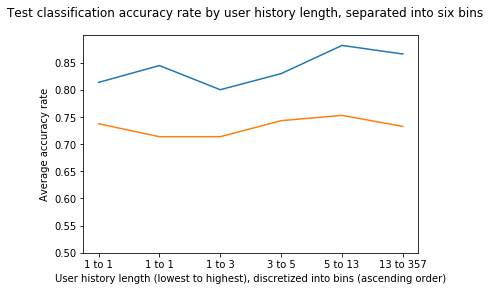

In [10]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.843267326732673
AUC: 0.7846362794278633
F1: 0.9120238724451277
Precision: 0.8723141723931317
Recall: 0.9555749636098981


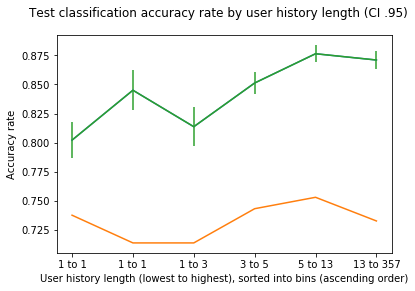

In [11]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [12]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'nohistory_baseline_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [13]:
# merge data

# merge data
X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                      X_labeled_train_img_norm),
                     axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                     X_labeled_test_img_norm),
                    axis = 1)

Strating ************************************************* 0
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.394
[1,   400] loss: 0.353
[1,   600] loss: 0.400
[1,   800] loss: 0.330
R2 score for bin 0 = -0.41052631578947407
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


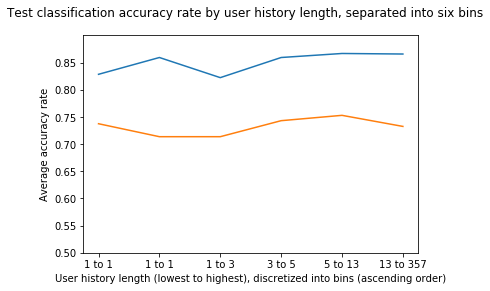

Strating ************************************************* 1
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.432
[1,   400] loss: 0.367
[1,   600] loss: 0.379
[1,   800] loss: 0.316
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


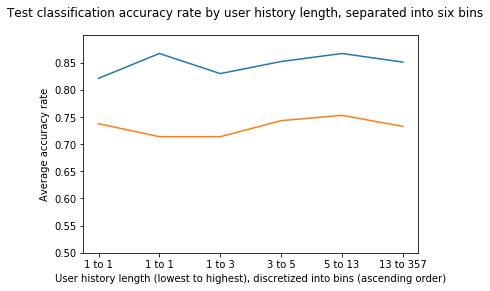

Strating ************************************************* 2
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.410
[1,   400] loss: 0.362
[1,   600] loss: 0.356
[1,   800] loss: 0.394
R2 score for bin 0 = -0.3491990846681925
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


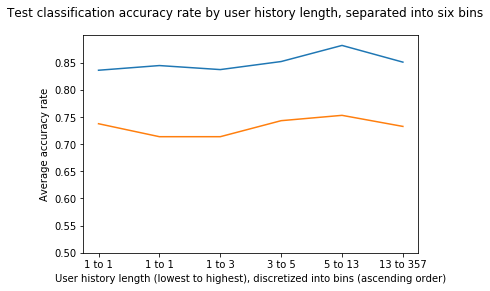

Strating ************************************************* 3
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.424
[1,   400] loss: 0.364
[1,   600] loss: 0.332
[1,   800] loss: 0.359
R2 score for bin 0 = -0.22654462242562956
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


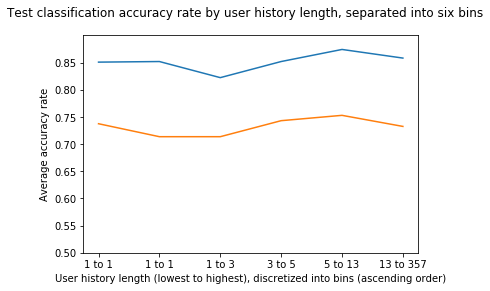

Strating ************************************************* 4
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.422
[1,   400] loss: 0.348
[1,   600] loss: 0.350
[1,   800] loss: 0.356
R2 score for bin 0 = -0.16521739130434798
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.06418918918918903
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


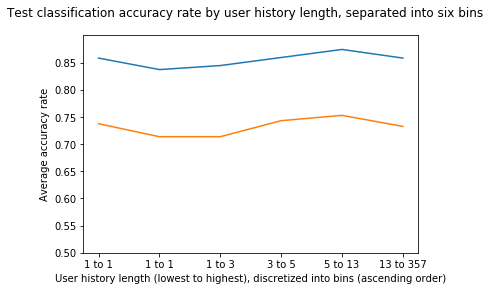

Strating ************************************************* 5
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.419
[1,   400] loss: 0.363
[1,   600] loss: 0.353
[1,   800] loss: 0.356
R2 score for bin 0 = -0.3491990846681925
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


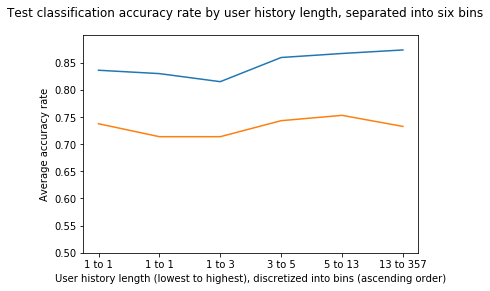

Strating ************************************************* 6
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.436
[1,   400] loss: 0.394
[1,   600] loss: 0.324
[1,   800] loss: 0.339
R2 score for bin 0 = -0.10389016018306663
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


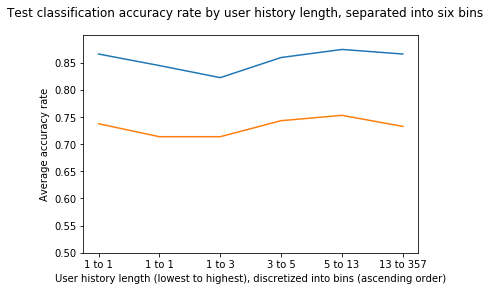

Strating ************************************************* 7
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.414
[1,   400] loss: 0.393
[1,   600] loss: 0.357
[1,   800] loss: 0.325
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.41891891891891886
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


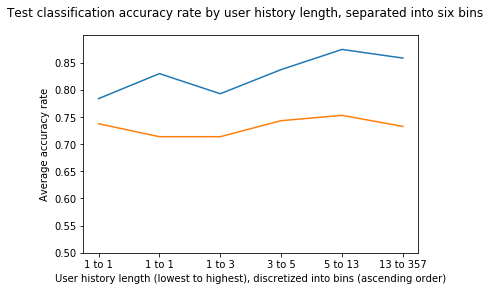

Strating ************************************************* 8
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.435
[1,   400] loss: 0.336
[1,   600] loss: 0.338
[1,   800] loss: 0.359
R2 score for bin 0 = -0.16521739130434798
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.06418918918918903
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


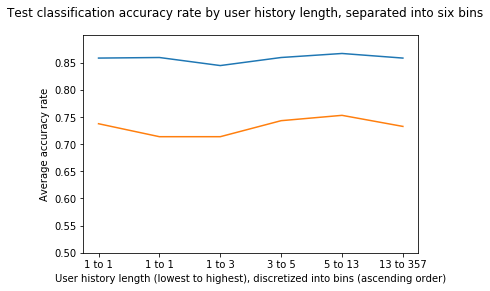

Strating ************************************************* 9
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.448
[1,   400] loss: 0.389
[1,   600] loss: 0.324
[1,   800] loss: 0.326
R2 score for bin 0 = -0.41052631578947407
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


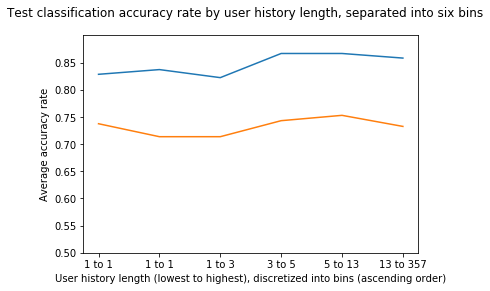

Strating ************************************************* 10
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.423
[1,   400] loss: 0.389
[1,   600] loss: 0.343
[1,   800] loss: 0.347
R2 score for bin 0 = -0.28787185354691114
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.23421052631578987
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


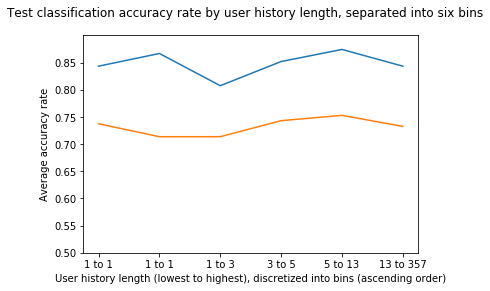

Strating ************************************************* 11
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.420
[1,   400] loss: 0.351
[1,   600] loss: 0.372
[1,   800] loss: 0.341
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


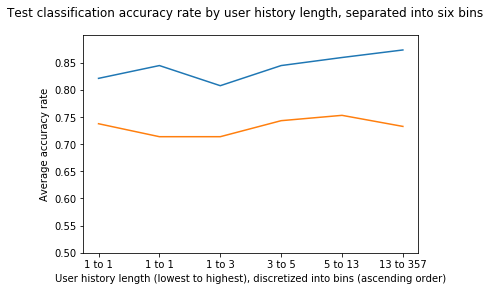

Strating ************************************************* 12
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.413
[1,   400] loss: 0.357
[1,   600] loss: 0.381
[1,   800] loss: 0.341
R2 score for bin 0 = -0.10389016018306663
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.013513513513513375
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


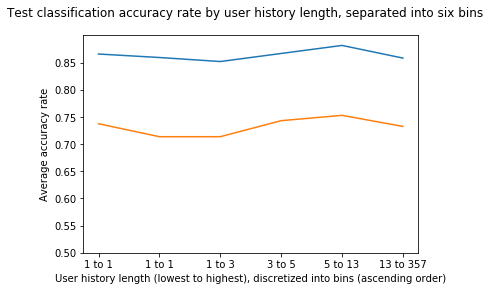

Strating ************************************************* 13
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.415
[1,   400] loss: 0.382
[1,   600] loss: 0.355
[1,   800] loss: 0.325
R2 score for bin 0 = -0.41052631578947407
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


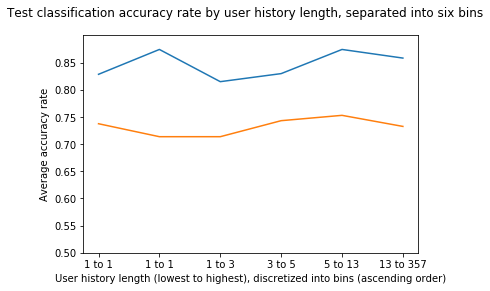

Strating ************************************************* 14
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.419
[1,   400] loss: 0.337
[1,   600] loss: 0.385
[1,   800] loss: 0.348
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.06418918918918903
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.29298245614035134
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


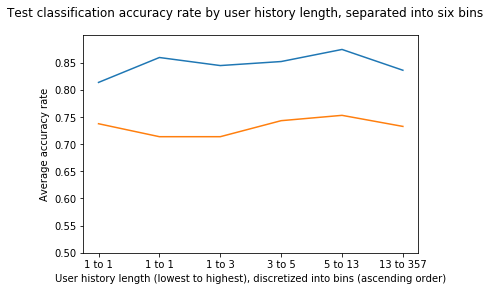

Strating ************************************************* 15
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.419
[1,   400] loss: 0.373
[1,   600] loss: 0.342
[1,   800] loss: 0.339
R2 score for bin 0 = -0.10389016018306663
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


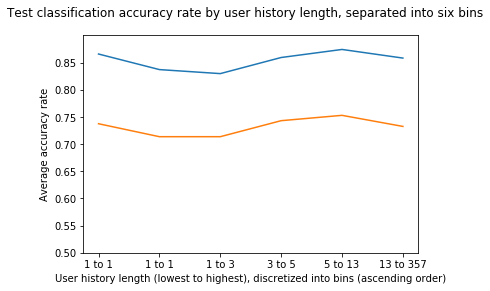

Strating ************************************************* 16
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.414
[1,   400] loss: 0.345
[1,   600] loss: 0.385
[1,   800] loss: 0.343
R2 score for bin 0 = -0.3491990846681925
R2 score for bin 1 = 0.18918918918918892
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


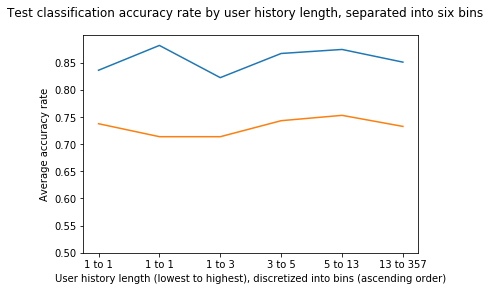

Strating ************************************************* 17
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.430
[1,   400] loss: 0.392
[1,   600] loss: 0.346
[1,   800] loss: 0.345
R2 score for bin 0 = -0.28787185354691114
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.06418918918918903
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


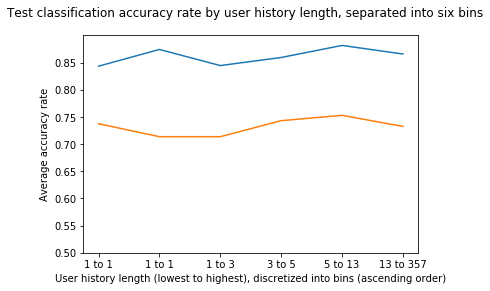

Strating ************************************************* 18
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.408
[1,   400] loss: 0.382
[1,   600] loss: 0.373
[1,   800] loss: 0.322
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


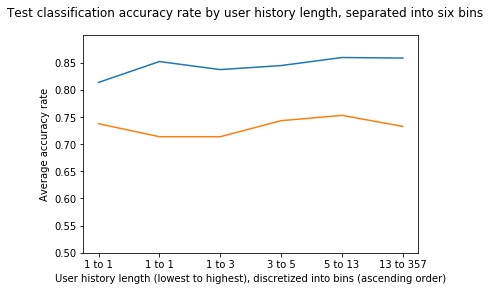

Strating ************************************************* 19
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.416
[1,   400] loss: 0.355
[1,   600] loss: 0.363
[1,   800] loss: 0.374
R2 score for bin 0 = -0.10389016018306663
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


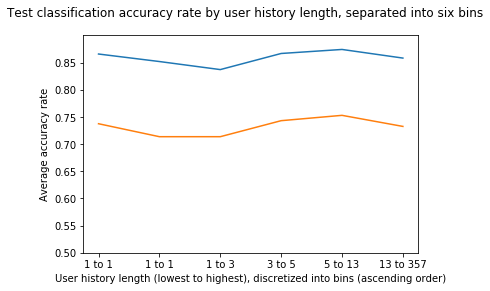

Strating ************************************************* 20
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.430
[1,   400] loss: 0.348
[1,   600] loss: 0.335
[1,   800] loss: 0.359
R2 score for bin 0 = -0.28787185354691114
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


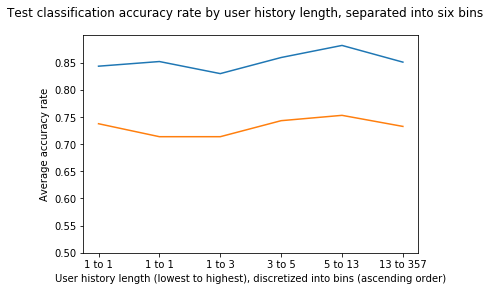

Strating ************************************************* 21
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.426
[1,   400] loss: 0.357
[1,   600] loss: 0.322
[1,   800] loss: 0.392
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


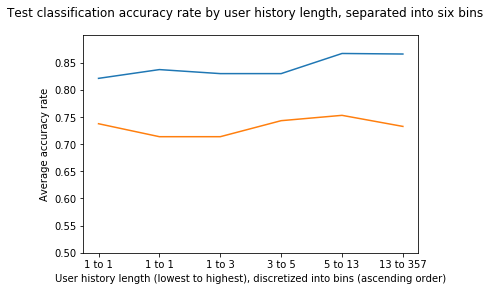

Strating ************************************************* 22
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.418
[1,   400] loss: 0.357
[1,   600] loss: 0.335
[1,   800] loss: 0.389
R2 score for bin 0 = -0.3491990846681925
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.5384615384615383
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


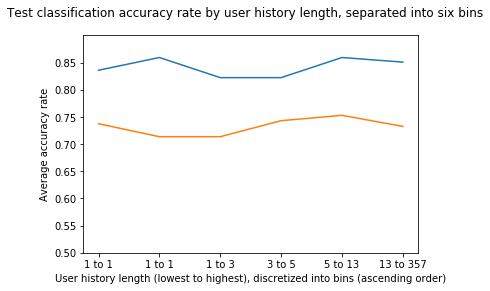

Strating ************************************************* 23
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.452
[1,   400] loss: 0.337
[1,   600] loss: 0.350
[1,   800] loss: 0.352
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


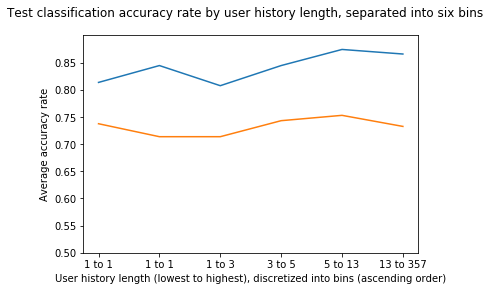

Strating ************************************************* 24
epoch: 0 learning rate: [0.02095663890266602]
[1,   200] loss: 0.417
[1,   400] loss: 0.331
[1,   600] loss: 0.364
[1,   800] loss: 0.368
R2 score for bin 0 = -0.10389016018306663
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.013513513513513375
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


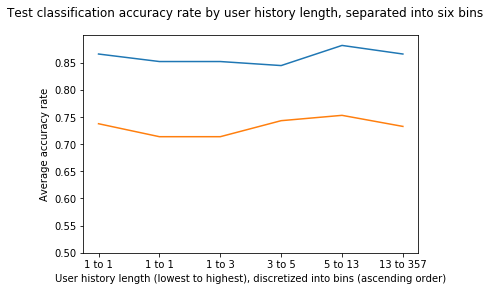

In [14]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)




Acc: 0.8499009900990099
AUC: 0.8085435538393061
F1: 0.916329134361448
Precision: 0.8705872005775339
Recall: 0.9676273653566229


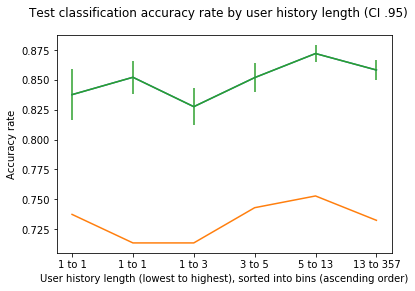

In [15]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)